In [1]:
# Step 31

import csv
from sklearn.metrics import precision_recall_curve, auc
y_scores = []
myReader = csv.reader(open("./sa_models_benchmarking/withheld_results.csv", 'r'),delimiter=',')
for row in myReader:
    try:
        y_scores.append(float(row[1]))
    except:
        pass
y_true = []
myReader = csv.reader(open("./sa_models_benchmarking/withheld.csv", 'r'),delimiter=',')
for row in myReader:
    try:
        y_true.append(float(row[1]))
    except:
        pass

precision, recall, _ = precision_recall_curve(y_true, y_scores)
print(auc(recall, precision))


0.4403008079845226


In [2]:
# Step 36

import csv
from rdkit import Chem
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
hits = []
myReader = csv.reader(open("./all_test_results.csv", 'r'),delimiter=',')
for row in myReader:
    mol = Chem.MolFromSmiles(row[0])
    if mol is not None and float(row[1])>0.2 and float(row[2])<0.2 and float(row[3])<0.05 and float(row[4])<0.2:
        hits.append(mol)

params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
catalog = FilterCatalog(params)
filtered_hits = []
for i in hits:
    entry = catalog.GetFirstMatch(i)  
    if entry is None:
         # Collect hits without PAINS or Brenk substructures
        filtered_hits.append(i)


[13:10:34] SMILES Parse Error: syntax error while parsing: SMILES
[13:10:34] SMILES Parse Error: Failed parsing SMILES 'SMILES' for input: 'SMILES'
[13:10:37] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)[i]c1ccccc12
[13:10:37] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)[i]c1ccccc12' for input: 'c1ccc2c(c1)[i]c1ccccc12'
[13:10:39] WARNING: not removing hydrogen atom without neighbors


In [3]:
len(filtered_hits)

203

In [4]:
# Step 37

from rdkit import DataStructs
from rdkit.Chem import AllChem
train = []
myReader = csv.reader(open("./sa_models/train.csv", 'r'),delimiter=',')
for row in myReader:
    mol = Chem.MolFromSmiles(row[0])
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048) 
        train.append(fingerprint)

tanimoto = []
for mol in filtered_hits:
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048) 
    max_similarity = 0
    for train_fingerprint in train:
        tanimoto_similarity = DataStructs.FingerprintSimilarity(fingerprint,train_fingerprint)
        if tanimoto_similarity > max_similarity:
            max_similarity = tanimoto_similarity
    tanimoto.append(max_similarity)

filtered_hits_tanimoto=[filtered_hits[i] for i in range(len(tanimoto)) if tanimoto[i] < 0.5]


[13:10:45] SMILES Parse Error: syntax error while parsing: SMILES
[13:10:45] SMILES Parse Error: Failed parsing SMILES '﻿SMILES' for input: '﻿SMILES'


In [5]:
len(filtered_hits_tanimoto)

182

[13:10:51] SMILES Parse Error: syntax error while parsing: SMILES
[13:10:51] SMILES Parse Error: Failed parsing SMILES '﻿SMILES' for input: '﻿SMILES'
/Users/felix/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/felix/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/felix/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConver

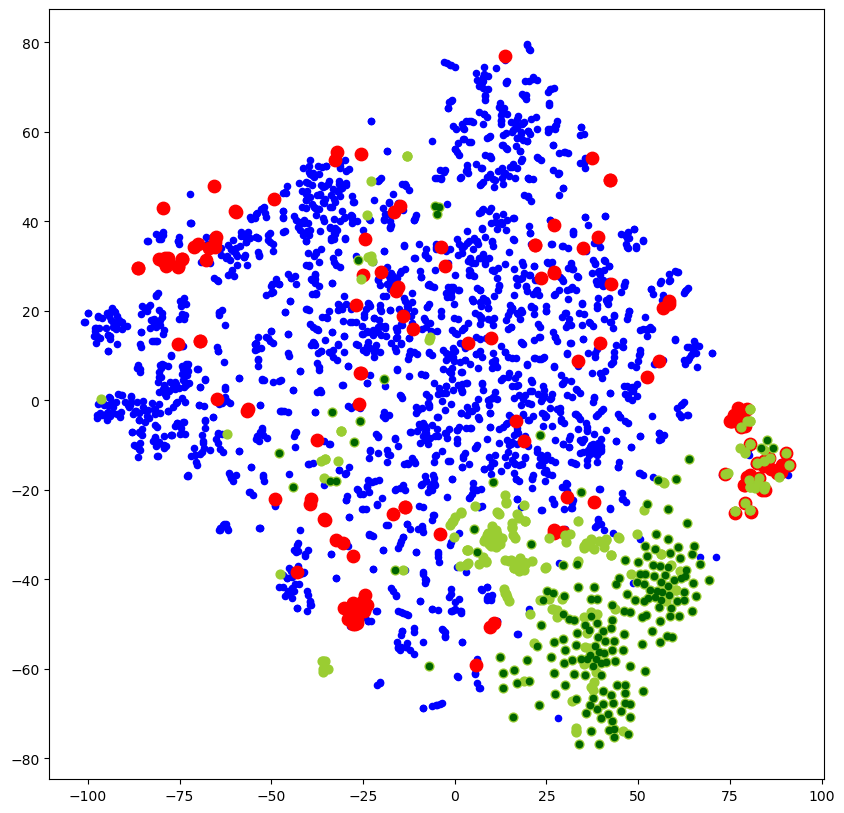

In [6]:
# Step 38 

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns    
import matplotlib.pyplot as plt

# Read and classify molecules
def read_molecules(file_path):
    train_pos, train_neg = [], []
    with open(file_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            mol = Chem.MolFromSmiles(row[0])
            if mol:
                if float(row[1]) == 1:
                    train_pos.append(mol)
                else:
                    train_neg.append(mol)
    return train_pos, train_neg

# Calculate fingerprint array
def calc_fp_arr(mols):
    fplist = []
    for mol in mols:
        arr = np.zeros((1,))
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fplist.append(arr)
    return np.asarray(fplist)

# Load data
train_pos, train_neg = read_molecules("./sa_models/train.csv")

# Combine all data
alldata = [train_neg, train_pos, hits, filtered_hits_tanimoto]
flatalldata = [item for sublist in alldata for item in sublist]
alllengths = [len(data) for data in alldata]

# Calculate fingerprints and apply TSNE
res = calc_fp_arr(flatalldata)
model = TSNE(n_components=2, init="pca", perplexity=30, metric='jaccard')
x = model.fit_transform(res)
df1 = pd.DataFrame(x, columns=['x1', 'y1'])

# Split data
lengths = np.cumsum(alllengths)
lengths = np.insert(lengths, 0, 0)
dfs = [df1[lengths[i]:lengths[i+1]] for i in range(len(lengths)-1)]

# Plot data
colors = ['blue', 'red', 'yellowgreen', 'darkgreen']
sizes = [20, 80, 40, 20]

plt.figure(figsize=(10, 10))
for df, color, size in zip(dfs, colors, sizes):
    plt.scatter(df['x1'], df['y1'], color=color, s=size)
plt.show()


[13:11:05] SMILES Parse Error: syntax error while parsing: rationales
[13:11:05] SMILES Parse Error: Failed parsing SMILES 'rationales' for input: 'rationales'


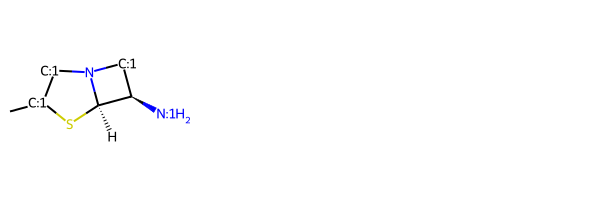

In [7]:
# Step 41

from rdkit.Chem import Draw

rationales = []
myReader = csv.reader(open("./rationales.csv", 'r'),delimiter=',')
for row in myReader:
    rationale = Chem.MolFromSmiles(row[0])
    if rationale is not None:
        rationales.append(rationale)

Draw.MolsToGridImage(rationales)


In [8]:
# Step 42 using the single rationale above and a generic b-lactam ring

rationale_1=rationales[0]
rationale_2=Chem.MolFromSmiles("C1CNC1=O")

from rdkit.Chem import rdFMCS
this_MCS = Chem.MolFromSmarts(rdFMCS.FindMCS([rationale_1,rationale_2],bondCompare=rdFMCS.BondCompare.CompareOrderExact,completeRingsOnly=True).smartsString)


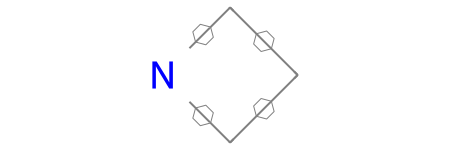

In [9]:
this_MCS

In [10]:
# Step 43 

associated_mols = []
for mol in filtered_hits:
    if mol.HasSubstructMatch(this_MCS):
        associated_mols.append(mol)
len(associated_mols)

23

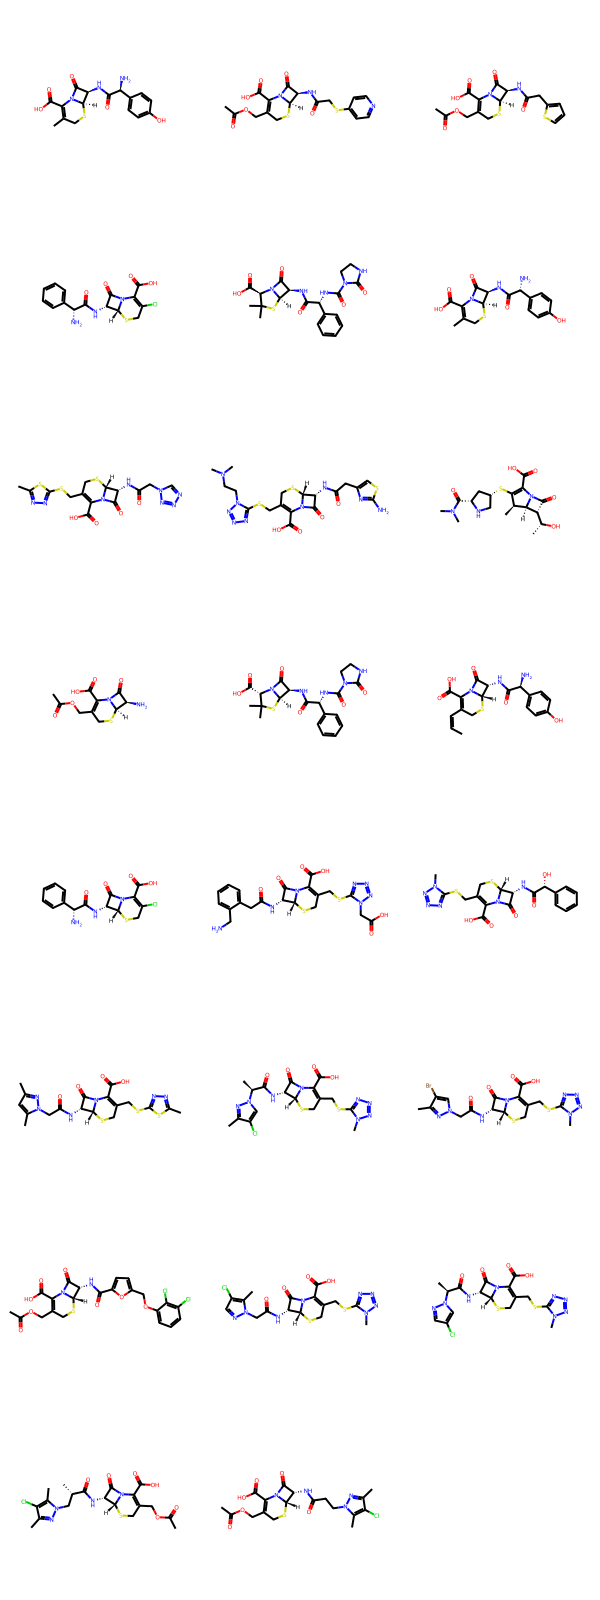

In [11]:
Draw.MolsToGridImage(associated_mols)